In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

import math

from sklearn import preprocessing

from scipy import stats
import scipy.stats as st
import scipy as sci

import random

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.spatial.distance import minkowski

In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [12]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [13]:
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

Some helpers functions

In [14]:
def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [15]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [16]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(X_train, X_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)  
  return y_pred

In [17]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
  C = metrics.confusion_matrix(y_test, y_pred)
  accuracy = np.trace(C) / len(y_test)
  if verbose == 1:
    print("The number of true negatives is:", C[0, 0])
    print("The number of false negatives is:", C[1,0])
    print("The number of false positives is:", C[0,1])  
    print("The number of true positives is:", C[1,1])
    print("The accuracy is:", accuracy)
    print("The accuracy on the 1's is ", 1 / np.sum(y_test == 1) * (np.sum(y_test == 1) - C[1, 0]))
    print("The accuracy on the 0's is ", 1 / np.sum(y_test == 0) * (np.sum(y_test == 0) - C[0, 1]))
  return accuracy

In [18]:
from sklearn import metrics

def weighted_balance_average(y_true, y_pred):
    ones_number = np.count_nonzero(y_true == 1.)
    frequency_1 = ones_number / len(y_true)
    frequency_0 = 1 - frequency_1
    sum_inverse_frequencies = 1 / frequency_0 + 1 / frequency_1
    weight_0 = 1 / (frequency_0 * sum_inverse_frequencies)
    weight_1 = 1 / (frequency_1 * sum_inverse_frequencies)
    C = metrics.confusion_matrix(y_true, y_pred)
    return weight_0 * C[0, 0] / (C[0, 0] + C[0, 1]) + weight_1 * C[1, 1] / (C[1, 1] + C[1, 0])

In [19]:
from sklearn.ensemble import IsolationForest

def split_outliers(threshold, scores):
  outliers_indices = np.where(scores < threshold)[0]
  return outliers_indices

def Anomaly_Detection_Isolation_Forests(x, change_split=False):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

In [20]:
def split_importance(x, y, importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y >= importance_class], y[y >= importance_class], x[y < importance_class], y[y < importance_class]

In [21]:
#quantization function required for some score functions
def quantize(x,cuts=100):
  ranges = np.sort(np.unique(pd.cut(x,cuts)))
  for i in range(ranges.shape[0]):
    ranges_i = ranges[i]
    x[(x<=ranges_i.right)&(x>ranges_i.left)] = (ranges_i.left +ranges_i.right)/2
  return x

def quantize_features(x,cuts=100):
  return np.apply_along_axis(quantize,0,x,cuts)

#correlation scorers
def Spearman(i,j):
  ret,_ = spearmanr(i,j)
  return ret

def Correlation_Score(x,y):
  x = x.T
  score = [min([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Correlation_Score_Max(x,y):
  x = x.T
  score = [-max([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

In [22]:
def Furthest(x,z):
  """
  Returns the index of the sample in x which is furthest from all the samples in z
  :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
  :param z: numpy.ndarray: The array of the samples which we use as a point of reference
  :return: int: returns a single index corresponding to the furthest x
  """
  max_dist_i = 0
  max_dist = -1
  for i in range(x.shape[0]):
      distance = min([np.linalg.norm(j-x[i]) for j in z])
      if max_dist < distance :
          max_dist = distance
          max_dist_i = i 
  return max_dist_i

def PSU_undersampling(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling of the samples in the x,y arrays
  with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  C = np.mean(x,axis = 0)
  dist = np.linalg.norm(x-C,2,axis = 1)
  indices = dist.argsort()
  x = x[indices]
  y = y[indices]
  split_x = np.array_split(x,randomsize)
  split_y = np.array_split(y,randomsize)
  #indices = [Furthest(split_x[i],xi) for i in range(randomsize)]
  dst_samples = [split_x[0][-1]]
  y_samples = [split_y[0][-1]]
  for i in range(1,randomsize):
    print("Starting ",i," iteration")
    indice = Furthest(split_x[i],dst_samples)
    dst_samples.append(split_x[i][indice])
    y_samples.append(split_y[i][indice])
  x_resample = np.array(dst_samples)
  y_resample = np.array(y_samples)
  return x_resample,y_resample

def PSU_undersampling_reduced_dim(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling by first doing a dimensionality reduction
  of the samples in the x,y arrays with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  feature_scores =  Fisher_Score(xi,x)
  indices = np.sort((-feature_scores).argsort()[:10])
  x_filtered = x[:,indices]
  x_i = xi[:,indices]
  C = np.mean(x_filtered,axis = 0)
  dist = np.linalg.norm(x_filtered-C,2,axis = 1)
  indices = dist.argsort()
  x_filtered = x_filtered[indices]
  y = y[indices]
  split_x = np.array_split(x_filtered,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],x_i) for i in range(randomsize)]
  split_x = np.array_split(x,randomsize)
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample, y_resample

def stratified_undersampling(x, y, alpha=1, intervals = 0.05 * np.arange(0, 15)):
  """
  This function performs stratified undersampling on the majority class
  by dropping samples in each strata with a probability equal to the frequency
  :param x: the datapoints to be undersampled
  :param y: the corresponding labels
  :param alpha: a hyperparameter to choose the dropping probability 
  :param intervals: the stratification intervals
  :return x and y undersampled  
  """
  # just a check that we drop with high probability in the frequent strata
  assert alpha > 0.5
  to_drop = []
  # we do a cycle over all intervals
  for i in range(len(intervals)-1):
    # get the indices for which the label is in the i-th strata
    indices = np.where(np.logical_and(intervals[i] < y, y < intervals[i+1]))[0]
    # compute the frequency of the i-th strata
    frequency = len(indices) / len(y)
    # we do a cycle over all elements in such a stratum
    for j in range(len(indices)):
      # we draw a uniform random variable
      U = st.uniform.rvs(size=1)
      if U <= alpha * frequency:
        # we drop every sample in the i-th strata with probability alpha * frequency
        to_drop.append(indices[j])
  # we drop from x and y the samples and the labels found before
  x_new = np.delete(x, to_drop, axis=0)
  y_new = np.delete(y, to_drop, axis=0)
  return x_new, y_new

In [31]:
def Fisher_Score(x_import, x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import,axis = 0)
  mean_nimport = np.mean(x_nimport,axis = 0)
  mean_dist = np.absolute(mean_import-mean_nimport)
  std_import = np.std(x_import,axis=0)
  std_nimport = np.std(x_nimport,axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x, distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x, y, randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x, y, neighbors, N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def random_sampler(x,y,randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf(x, y, undersample=0.1, oversample = 0.3, attribute_scorer=Fisher_Score, 
             attribute_number = 10, distance = float('inf'), kneighbors = 3,
             undersampling=stratified_undersampling, importance_class = 0.7, alpha=1, width_strata=0.05):
  """
  This function takes the complete input and produces a more balanced dataset based on the importance class
  :param x: numpy.ndarray: the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param undersample: float: the percentage of the dominant class that we want to keep
  :param oversample: float: the percentage of the dataset that the small class will be at the end
  :param attribute_scorer: function: a function which will be used to score the relevance of a feature
  :param attribute_number: int: the number of attributes to keep according to their score
  :param distance: float: the norm which should be used for the Minkowski distance
  :param kneighbors: int: the number of samples which should be considered for each point 
  :param undersampling: function: the function to use for the undersampling of the majority class
  :param importance_class: float: the lower bound for the underepresented class
  :return: returns 2 new feature vectors and 2 new label vectors containing 
            the data for the importance class and the data for the non importance 
            class and their labels. 
  """
  x_import = x[y>=importance_class]
  y_import = y[y>=importance_class]
  x_nimport = x[y<importance_class]
  y_nimport = y[y<importance_class]

  feature_scores =  attribute_scorer(x_import,x_nimport)
  #find the attribute_number highest coordinates of the feature_scores vector
  indices = np.sort((-feature_scores).argsort()[:attribute_number])
  x_import_filtered = x_import[:,indices]
  #x_nimport = x_nimport[:,indices]
  distances = calculate_distances(x_import_filtered,distance)
  #find the k lowest indices
  neighbors = np.array([ np.sort(d.argsort()[:(kneighbors)]) for d in distances])
  #undersampling for the majority class
  intervals = width_strata * np.arange(int(importance_class / width_strata))
  nimport_len = int(undersample*y_nimport.shape[0])
  x_nimport,y_nimport = PSU_undersampling(x_nimport, y_nimport, nimport_len, x_import, y_import)
  #Calculate the number of samples to be generated
  N = int(oversample*(y_nimport.shape[0]) - y_import.shape[0])
  #Generate N new samples
  new_samples_x,new_samples_y = generate_samples(x_import, y_import, neighbors, N)
  #merge the new samples of the minority class with its old samples
  x_import = np.concatenate((x_import,new_samples_x))
  y_import = np.concatenate((y_import,new_samples_y))

  x_ret = np.concatenate((x_import, x_nimport))
  y_ret = np.concatenate((y_import, y_nimport))
  return x_ret, y_ret

In [32]:
def resampling_tuning(undersampling_grid, oversampling_grid):
  accuracies = np.zeros((len(undersampling_grid), len(oversampling_grid)))

  x_1, y_1, x_0, y_0 = split_importance(training_data, RelKa)
  x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)
  x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.3, random_state=42)

  x_train = np.concatenate((x_1_train, x_0_train))
  y_train = np.concatenate((y_1_train, y_0_train))
  x_test = np.concatenate((x_1_test, x_0_test))
  y_test = np.concatenate((y_1_test, y_0_test))
      
  sc = StandardScaler()
  x_train = sc.fit_transform(x_train)
  x_test = sc.transform(x_test)

  y_train = split_RelKa(y_train, 0.7)
  y_test = split_RelKa(y_test, 0.7)

  for i in range(len(undersampling_grid)):
    for j in range(len(oversampling_grid)):

      print("Currently performing", undersampling_grid[i], "undersampling and", oversampling_grid[j], "oversampling")

      x_train_tilda, y_train_tilda = smote_sf(x_train, y_train, undersample=undersampling_grid[i], oversample=oversampling_grid[j], kneighbors=5)

      clf = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, min_samples_leaf = 1)
      clf.fit(x_train_tilda, y_train_tilda)
      y_pred = clf.predict(x_test)
      accuracies[i][j] = weighted_balance_average(y_test, y_pred)

  best_result = np.where(accuracies == np.amax(accuracies))
  # the optimal undersampling and oversampling rates 
  undersampling_rate_opt, oversampling_rate_opt = undersampling_grid[best_result[0]], oversampling_grid[best_result[1]]
  return undersampling_rate_opt, oversampling_rate_opt

UNDERSAMPLING AND OVERSAMPLING CROSS-VALIDATION TECHNIQUE

In [33]:
x_1, y_1, x_0, y_0 = split_importance(training_data, RelKa)

In [34]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.3, random_state=42)

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

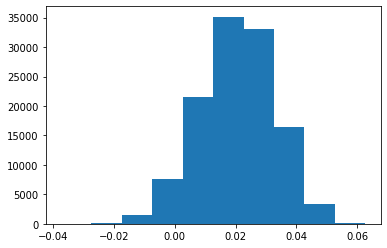

The indecision percentage around 0.02 is 0.3294876304373314
The percentage of outliers detected is 0.05331435032033834


In [35]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [36]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [38]:
x_train, y_train = smote_sf(x_train, y_train)

Output streaming troncato alle ultime 5000 righe.
Starting  6281  iteration
Starting  6282  iteration
Starting  6283  iteration
Starting  6284  iteration
Starting  6285  iteration
Starting  6286  iteration
Starting  6287  iteration
Starting  6288  iteration
Starting  6289  iteration
Starting  6290  iteration
Starting  6291  iteration
Starting  6292  iteration
Starting  6293  iteration
Starting  6294  iteration
Starting  6295  iteration
Starting  6296  iteration
Starting  6297  iteration
Starting  6298  iteration
Starting  6299  iteration
Starting  6300  iteration
Starting  6301  iteration
Starting  6302  iteration
Starting  6303  iteration
Starting  6304  iteration
Starting  6305  iteration
Starting  6306  iteration
Starting  6307  iteration
Starting  6308  iteration
Starting  6309  iteration
Starting  6310  iteration
Starting  6311  iteration
Starting  6312  iteration
Starting  6313  iteration
Starting  6314  iteration
Starting  6315  iteration
Starting  6316  iteration
Starting  6317

In [39]:
y_train = split_RelKa(y_train, 0.7)
y_test = split_RelKa(y_test, 0.7)

In [40]:
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, min_samples_leaf = 1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 50822
The number of false negatives is: 7
The number of false positives is: 255
The number of true positives is: 91
The accuracy is: 0.9948803126526624
The accuracy on the 1's is  0.9285714285714285
The accuracy on the 0's is  0.9950075376392505


0.9948803126526624